# K factor regressions

Can we explain how much the peak hour occupancy changed given the other variables (total occupancy, total flow, district, urban)? 

In [30]:
using CSV
using Parquet
using DataFrames
using Plots
using Dates
using CategoricalArrays
using Missings
using Random
using Statistics
using StatsBase
using Glob
using Latexify
using GLM

include("../code/KFactors.jl")
using .KFactors

LoadError: ArgumentError: Package GLM not found in current path:
- Run `import Pkg; Pkg.add("GLM")` to install the GLM package.


In [6]:
data = read_data("../data/all_district_peaks.parquet", "../data/sensor_meta_geo.csv")

┌ Info: Observations in each period
│   combine(groupby(data, :period), nrow) = 4×2 DataFrame
 Row │ period        nrow     
     │ Cat…?         Int64    
─────┼────────────────────────
   1 │ missing       33374822
   2 │ pandemic        600398
   3 │ postpandemic    610746
   4 │ prepandemic    2345492
└ @ Main.KFactors /Users/shzh8108/research/peak-spreading/code/KFactors.jl:67
┌ Info: Before filtering, data has 36931458 rows
└ @ Main.KFactors /Users/shzh8108/research/peak-spreading/code/KFactors.jl:78
┌ Info: After filtering, data has 1058197 rows
└ @ Main.KFactors /Users/shzh8108/research/peak-spreading/code/KFactors.jl:96


1058197×15 DataFrame
     Row │ station  peak_hour_occ  total_occ  total_flow  station_type  freewa ⋯
         │ Int64?   Float64?       Float64?   Int64?      String?       Int64? ⋯
─────────┼──────────────────────────────────────────────────────────────────────
       1 │  311903      0.223887     17.5816       58664  ML                   ⋯
       2 │  311974      0.141825     27.0884      119951  ML
       3 │  312010      0.117785     30.8537      126821  ML
       4 │  312098      0.15065      14.999        81951  ML
       5 │  312103      0.139201     27.9602      111184  ML                   ⋯
       6 │  312132      0.0835256    14.0448       29177  ML
       7 │  312133      0.175712     13.764        40745  ML
       8 │  312134      0.0979794    20.3706       37619  ML
       9 │  312139      0.130753     31.0624      131499  ML                   ⋯
      10 │  312188      0.111661     14.5646      105174  ML
      11 │  312205      0.0833179    17.3108      102028  ML
    ⋮    │    ⋮           ⋮            ⋮          ⋮            ⋮               ⋱
 1058188 │ 1038010      0.0748416     7.7978       27616  ML
 1058189 │ 1016710      0.0692323    13.9877       79537  ML                   ⋯
 1058190 │ 1037910      0.0784605     6.5893       22961  ML
 1058191 │ 1038010      0.0784605     6.5893       22961  ML
 1058192 │ 1016710      0.0733062    14.494        79577  ML
 1058193 │ 1037910      0.0780356     6.4996       22061  ML                   ⋯
 1058194 │ 1038010      0.0780356     6.4996       22061  ML
 1058195 │ 1016710      0.0671778    14.3485       80078  ML
 1058196 │ 1037910      0.0760734     6.7987       22997  ML
 1058197 │ 1038010      0.0760734     6.7987       22997  ML                   ⋯
                                             10 columns and 1058176 rows omitted

In [13]:
show(first(data, 5), allcols=true)

5×15 DataFrame
 Row │ station  peak_hour_occ  total_occ  total_flow  station_type  freeway_number  direction  day_of_week  District  urban  date        peak_hour_start  period       dayofweek  present_in_all_periods 
     │ Int64?   Float64?       Float64?   Int64?      String?       Int64?          String?    String?      Int64?    Bool?  Date        Time?            Cat…?        Cat…       Bool                   
─────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │  311903       0.223887    17.5816       58664  ML                        50  E          Wednesday           3   true  2016-06-15  07:30:00         prepandemic  Wednesday                    true
   2 │  311974       0.141825    27.0884      119951  ML                        50  E          Wednesday           3   true  2016-06-15  07:40:00         prepandemic  Wednesday  

In [159]:
prepandemic_avg = combine(groupby(data[data.period .== "prepandemic", :], :station), :peak_hour_occ => mean => :avg_peak_hour_occ, :total_occ => mean => :avg_total_occ, :total_flow => mean => :avg_total_flow, :District => first => :District, :urban => first => :urban)
pandemic_avg = combine(groupby(data[data.period .== "pandemic", :], :station), :peak_hour_occ => mean => :avg_peak_hour_occ, :total_occ => mean => :avg_total_occ, :total_flow => mean => :avg_total_flow, :District => first => :District, :urban => first => :urban)
postpandemic_avg = combine(groupby(data[data.period .== "postpandemic", :], :station), :peak_hour_occ => mean => :avg_peak_hour_occ, :total_occ => mean => :avg_total_occ, :total_flow => mean => :avg_total_flow, :District => first => :District, :urban => first => :urban)

prepandemic_avg.log_avg_peak_hour_occ = log.(prepandemic_avg.avg_peak_hour_occ)
pandemic_avg.log_avg_peak_hour_occ = log.(pandemic_avg.avg_peak_hour_occ)
postpandemic_avg.log_avg_peak_hour_occ = log.(postpandemic_avg.avg_peak_hour_occ)

nothing

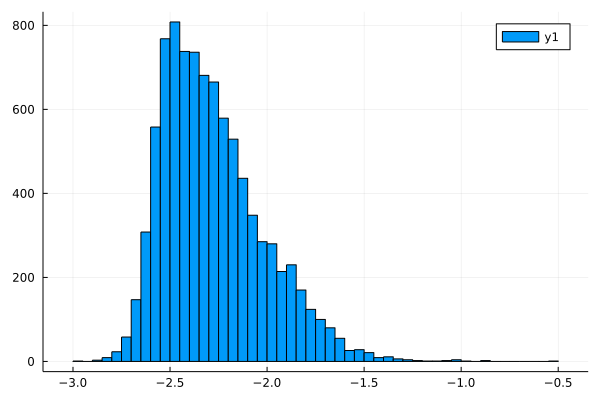

In [147]:
histogram(log.(prepandemic_avg.avg_peak_hour_occ))

In [162]:
prepandemic_model = lm(@formula(log_avg_peak_hour_occ ~ avg_total_occ + avg_total_flow + District + urban), contrasts=Dict(:District => DummyCoding()), prepandemic_avg)
#prepandemic_model = lm(@formula(avg_peak_hour_occ ~ avg_total_occ + avg_total_flow + urban), prepandemic_avg)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

log_avg_peak_hour_occ ~ 1 + avg_total_occ + avg_total_flow + District + urban

Coefficients:
─────────────────────────────────────────────────────────────────────────────────────
                      Coef.   Std. Error        t  Pr(>|t|)    Lower 95%    Upper 95%
─────────────────────────────────────────────────────────────────────────────────────
(Intercept)     -2.29127     0.0128779    -177.92    <1e-99  -2.31651     -2.26602
avg_total_occ    0.00649966  0.000409293    15.88    <1e-55   0.00569736   0.00730197
avg_total_flow  -2.09113e-6  1.12489e-7    -18.59    <1e-74  -2.31163e-6  -1.87062e-6
District: 4      0.0742234   0.0117807       6.30    <1e-09   0.0511305    0.0973163
District: 5     -0.010685    0.0166119      -0.64    0.5201  -0.0432482    0.0218781
District: 6     -0.175351    0.0151961     -11

In [164]:
postpandemic_model = lm(@formula(log_avg_peak_hour_occ ~ avg_total_occ + avg_total_flow + District + urban), contrasts=Dict(:District => DummyCoding()), postpandemic_avg)
#postpandemic_model = lm(@formula(log_avg_peak_hour_occ ~ avg_total_occ + avg_total_flow + urban), postpandemic_avg)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

log_avg_peak_hour_occ ~ 1 + avg_total_occ + avg_total_flow + District + urban

Coefficients:
─────────────────────────────────────────────────────────────────────────────────────
                      Coef.   Std. Error        t  Pr(>|t|)    Lower 95%    Upper 95%
─────────────────────────────────────────────────────────────────────────────────────
(Intercept)     -2.44069     0.0122562    -199.14    <1e-99  -2.46471     -2.41666
avg_total_occ    0.00757463  0.000389213    19.46    <1e-81   0.00681168   0.00833757
avg_total_flow  -1.87412e-6  1.07554e-7    -17.42    <1e-66  -2.08495e-6  -1.66329e-6
District: 4      0.097506    0.0113441       8.60    <1e-17   0.075269     0.119743
District: 5      0.139112    0.016002        8.69    <1e-17   0.107744     0.170479
District: 6     -0.0968295   0.0146243      -6.6

In [165]:
scatter(
    predict(prepandemic_model),
    prepandemic_avg.log_avg_peak_hour_occ,
    markeralpha=0.1,
    markercolor="blue",
)

scatter!(
    predict(prepandemic_model, postpandemic_avg),
    postpandemic_avg.log_avg_peak_hour_occ,
    markeralpha=0.1,
    markercolor="red"
)

In [166]:
prepandemic_predicted_with_prepandemic_model = predict(prepandemic_model)
postpandemic_predicted_with_prepandemic_model = predict(prepandemic_model, postpandemic_avg)
postpandemic_predicted_with_postpandemic_model = predict(postpandemic_model, postpandemic_avg)

non_missing_ix_pre_pre = collect(keys(skipmissing(prepandemic_predicted_with_prepandemic_model)))
non_missing_ix_pre_post = collect(keys(skipmissing(postpandemic_predicted_with_prepandemic_model)))
non_missing_ix_post_post = collect(keys(skipmissing(postpandemic_predicted_with_postpandemic_model)))

9023-element Vector{Int64}:
    1
    2
    3
    4
    5
    6
    7
    8
    9
   10
   11
   12
   13
    ⋮
 9016
 9017
 9018
 9019
 9020
 9021
 9022
 9023
 9024
 9025
 9026
 9027

In [169]:
r2(prepandemic_model)

0.14310912094694817

In [171]:
r2(postpandemic_model)

0.10390812739965949

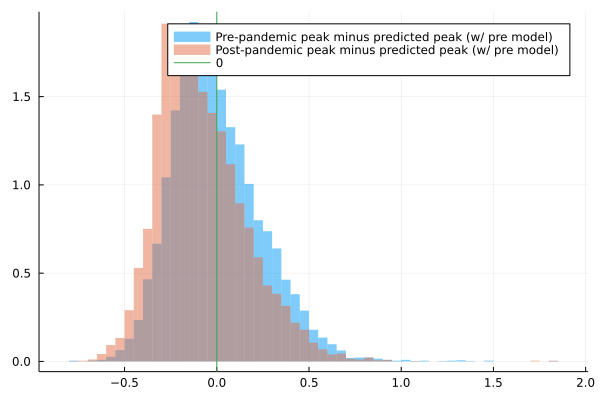

In [175]:
histogram(prepandemic_avg.log_avg_peak_hour_occ[keys(non_missing_ix_pre_pre)] - collect(skipmissing(prepandemic_predicted_with_prepandemic_model)), normalize=true, alpha=0.5, label="Pre-pandemic peak minus predicted peak (w/ pre model)", lw=0)
histogram!(postpandemic_avg.log_avg_peak_hour_occ[keys(non_missing_ix_pre_post)] - collect(skipmissing(postpandemic_predicted_with_prepandemic_model)), normalize=true, alpha=0.5, label="Post-pandemic peak minus predicted peak (w/ pre model)", lw=0)
#histogram!(postpandemic_avg.avg_peak_hour_occ[keys(non_missing_ix_post_post)] - collect(skipmissing(postpandemic_predicted_with_postpandemic_model)), normalize=true, alpha=0.5, label="Post-pandemic peak - predicted peak (w/ post model)", xlim=[-0.1, 0.2], lw=0)

vline!([0], label="0")

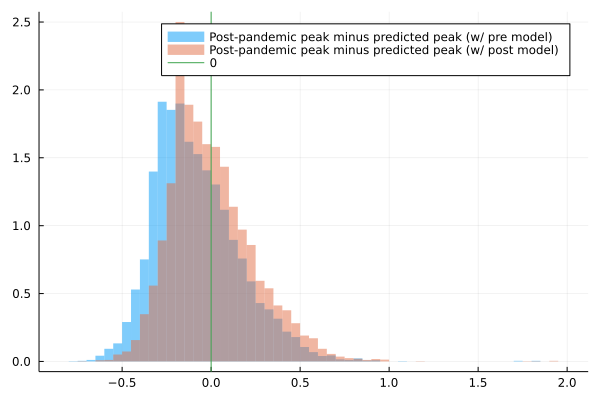

In [177]:
#histogram(prepandemic_avg.avg_peak_hour_occ[keys(non_missing_ix_pre_pre)] - collect(skipmissing(prepandemic_predicted_with_prepandemic_model)), normalize=true, alpha=0.5, label="Pre-pandemic peak - predicted peak (w/ pre model)", xlim=[-0.1, 0.2], lw=0)
histogram(postpandemic_avg.log_avg_peak_hour_occ[keys(non_missing_ix_pre_post)] - collect(skipmissing(postpandemic_predicted_with_prepandemic_model)), normalize=true, alpha=0.5, label="Post-pandemic peak minus predicted peak (w/ pre model)", lw=0)
histogram!(postpandemic_avg.log_avg_peak_hour_occ[keys(non_missing_ix_post_post)] - collect(skipmissing(postpandemic_predicted_with_postpandemic_model)), normalize=true, alpha=0.5, label="Post-pandemic peak minus predicted peak (w/ post model)", lw=0)

vline!([0], label="0")

In [11]:
# use -1 as missing value to prevent bounds errors in indexing below, you can't index with missing
data_prepost.District = coalesce.(data_prepost.District, [-1])
begin end

In [19]:
# there shouldn't be any stations missing districts - investigate
unique(data.station[ismissing.(data.District)])

18-element Vector{Union{Missing, Int64}}:
    312530
    317896
 501010124
    601372
    602372
    615821
    615841
    619981
    619983
    619984
    619987
    629987
    629991
    629993
    629994
   1037910
   1038010
   1016710

In [20]:
permutation_tests = DataFrame([
    (label="Overall", permutation_test(data_prepost)...),
    # some stations missing geo info, don't include in either urban or rural
    (label="Urban", permutation_test(data_prepost[coalesce.(data_prepost.urban, [false]), :])...),
    (label="Rural", permutation_test(data_prepost[coalesce.(.!data_prepost.urban, [false]), :])...),
    (label="District 3 (Sacramento)", permutation_test(data_prepost[data_prepost.District .== 3, :])...),
    (label="District 10 (Stockton)", permutation_test(data_prepost[data_prepost.District .== 10, :])...),
    (label="District 4 (San Francisco Bay Area)", permutation_test(data_prepost[data_prepost.District .== 4, :])...),
    (label="District 5 (Central Coast)", permutation_test(data_prepost[data_prepost.District .== 5, :])...),
    # The Freakersfield district
    (label="District 6 (Fresno / Bakersfield)", permutation_test(data_prepost[data_prepost.District .== 6, :])...),
    (label="District 7 (Los Angeles)", permutation_test(data_prepost[data_prepost.District .== 7, :])...),
    (label="District 12 (Orange County)", permutation_test(data_prepost[data_prepost.District .== 12, :])...),
    (label="District 8 (Inland Empire)", permutation_test(data_prepost[data_prepost.District .== 8, :])...),
    (label="District 11 (San Diego)", permutation_test(data_prepost[data_prepost.District .== 11, :])...)
])

1×4 DataFrame
 Row │ label    ptest        pval     n_sensors 
     │ String   Float64      Float64  Int64     
─────┼──────────────────────────────────────────
   1 │ Overall  -0.00856135      0.0       9061

In [68]:
permutation_tests_fmt = permutation_tests[:,:]
permutation_tests_fmt.ptest = round.(permutation_tests_fmt.ptest, sigdigits=2)
permutation_tests_fmt.pval = round.(permutation_tests_fmt.pval, sigdigits=2)
latexify(permutation_tests_fmt, env=:table, latex=false, booktabs=true)

L"\begin{tabular}{cccc}
\toprule
label & ptest & pval & n_sensors\\
\midrule
Overall & -0.0086 & 0.0 & 9061\\
Urban & -0.011 & 0.0 & 3981\\
Rural & -0.0066 & 0.0 & 5057\\
District 3 (Sacramento) & -0.014 & 0.0 & 520\\
District 10 (Stockton) & -0.0071 & 0.0 & 633\\
District 4 (San Francisco Bay Area) & -0.013 & 0.0 & 2390\\
District 5 (Central Coast) & 0.00033 & 0.69 & 364\\
District 6 (Fresno / Bakersfield) & -0.0041 & 0.0 & 500\\
District 7 (Los Angeles) & -0.0066 & 0.0 & 1890\\
District 12 (Orange County) & -0.013 & 0.0 & 958\\
District 8 (Inland Empire) & 0.00051 & 0.47 & 1086\\
District 11 (San Diego) & -0.012 & 0.0 & 702\\
\bottomrule
\end{tabular}
"